# MPC with LSTM

env: MPC_TFT

In [1]:
import numpy as np
import pandas as pd
import control

import matplotlib.pyplot as plt
import matplotlib.animation as animation
# from plotly.subplots import make_subplots
# import plotly.graph_objects as go

from sklearn.preprocessing import MinMaxScaler
import time

# For LSTM/Transformer models
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torchdiffeq import odeint as torch_odeint
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import functional as F
from pickle import dump, load

from autograd import jacobian, grad

# For ODE solving
from scipy.integrate import odeint
from scipy.optimize import minimize

# Cuda
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

from tqdm import tqdm
if torch.cuda.is_available():
    print("cuda is available")
else:
    print("cuda is NOT available")

# For TFT
from tqdm import tqdm_notebook as tqdm
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel, TiDEModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, IceCreamHeaterDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

cuda is NOT available


### Load LSTM

In [2]:
# ===== Additional MPC parameters ===================
M = 10 # Control Horizon

# ===== Load LSTM and Transformer parameters ========

class LSTMModel(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.lstm3 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.dropout3 = nn.Dropout(0.2)
        self.dense = nn.Linear(hidden_dim, out_features=10) 
        #Outputs a fixed size of 10 features regardless of the output_dim provided in the constructor
        #why is this hardcoded to 10?

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        x, _ = self.lstm3(x)
        x = self.dropout3(x)
        x = self.dense(x[:, -1, :])  # Assuming return_sequences=False in the last LSTM
        return x

# ===== Load MinMaxScaler ===========================
model_params = load(open('model_param.pkl', 'rb'))
scaler_1 = model_params["X_scaler"]
scaler_2 = model_params["Y_scaler"]
window   = model_params["window"]
P        = model_params["P"]

input_dim = 2
hidden_dim = 100
output_dim = P
num_layers = 3

pred_LSTM = LSTMModel(input_dim, hidden_dim, output_dim, num_layers).to(device)
state_dict = torch.load("my_best_LSTM_1D.pth")
pred_LSTM.load_state_dict(state_dict)
pred_LSTM.eval()

LSTMModel(
  (lstm1): LSTM(2, 100, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(100, 100, batch_first=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (lstm3): LSTM(100, 100, batch_first=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (dense): Linear(in_features=100, out_features=10, bias=True)
)

In [3]:
print(scaler_2)

MinMaxScaler(feature_range=(-1, 1))


In [4]:
test_input = torch.randn(1, 1, input_dim, requires_grad=True).to(device)  # Batch size 1, sequence length 5, feature size input_dim

# Forward pass through the LSTM model
output = pred_LSTM(test_input)

# Calculate the gradient of the output with respect to the input
gradients = torch.autograd.grad(output, test_input, grad_outputs=torch.ones_like(output), create_graph=True)[0]

print("Output of the LSTM model:", output)
print("Gradients with respect to the input:", gradients)

Output of the LSTM model: tensor([[-0.0563, -0.0580, -0.0620, -0.0653, -0.0590, -0.0569, -0.0632, -0.0519,
         -0.0486, -0.0970]], grad_fn=<AddmmBackward0>)
Gradients with respect to the input: tensor([[[0.0245, 0.0183]]], grad_fn=<TransposeBackward0>)


### Process model

In [5]:
def process_model(y,t,u,K,tau):
    '''
    ODE from the literature. One can simply replace this part with other models
    '''
    # arguments
    #  y   = outputs
    #  t   = time
    #  u   = input value
    #  K   = process gain
    #  tau = process time constant

    # calculate derivative
    dydt = (-y + K * u)/tau

    return dydt

In [6]:
def process_model_grad(y, u, K, tau):
    dydt = (-y + K * u) / tau
    return dydt

# Get the Jacobians for A and B
jac_A = jacobian(process_model_grad, 0)  # Derivative w.r.t. the first argument (state)
jac_B = jacobian(process_model_grad, 1)  # Derivative w.r.t. the second argument (control)

### MPC objective function

In [7]:
pred_LSTM_output = dict()
pred_LSTM_output["iter"] = 0

def MPC_LSTM_obj(
            u_hat,   # control input
            y_hat,   # predicted output, will be updated with the model prediction
            SP_hat,  # reference trajectory
            u,       # initial value/past input, size window
            y,       # initial value/past output, size window
            window,  # window size (past)
            P,       # predictive horizon
            M,       # control horizon
            multistep # switch between single step ahead prediction or multistep ahead prediction
):

    u_hat_P = np.ones(P-M) * u_hat[-1] # assuming the future value after M (control horizon) remain the same as the last term of the control input
    u_all = np.concatenate((u, u_hat, u_hat_P), axis = None) # len(u_all) and len(y_all) should be window+P for it appends the initial value to the list
    y_all = np.append(y,y_hat)

    # Normalize input, output
    X = np.transpose([u_all, y_all])
    Y = np.transpose([y_all])


    X_scaled = scaler_1.transform(X)
    Y_scaled = scaler_2.transform(Y)

    # Appending the window (past) and Prediction (future) arrays
    X_scaled_q = X_scaled.copy()
    Y_scaled_q = Y_scaled.copy()

    # === LSTM prediction ==============================================================
    if multistep == 0:
        pass

    else:
        # Reshape to fit into LSTM
        X_in_LSTM = X_scaled_q.reshape((1,window+P,np.shape(X_scaled_q)[1]))
        # Convert it into torch tensor
        X_in_LSTM = torch.from_numpy(X_in_LSTM).type(torch.float32).to(device)
        # LSTM prediction
        Y_scaled_q = pred_LSTM(X_in_LSTM).detach().to("cpu").numpy().reshape(-1,1)

    # inverse scaling
    Y_true_scale = scaler_2.inverse_transform(Y_scaled_q)
    pred_LSTM_output["LSTM_multi_predict"] = Y_true_scale

    u_hat0 = np.append(u[-1],u_hat)
    # === compute objective value ======================================================
    Obj = 10*np.sum((Y_true_scale - SP_hat.reshape(-1,1))**2) + np.sum(((u_hat0[1:] - u_hat0[0:-1])**2))
    pred_LSTM_output["MPC_LSTM_obj"] = Obj
    pred_LSTM_output["iter"] = pred_LSTM_output["iter"] +1
    return Obj


### MPC Main loop

#### Run one step only

LSTM single iteration time = 0.148604154586792, final obj val = 3.0975032814703436
best control action is [0.23837909 0.69011748 1.22229111 1.49934662 1.39013497 1.11876297
 0.94777902 0.93003904 0.94981341 0.9553631 ]


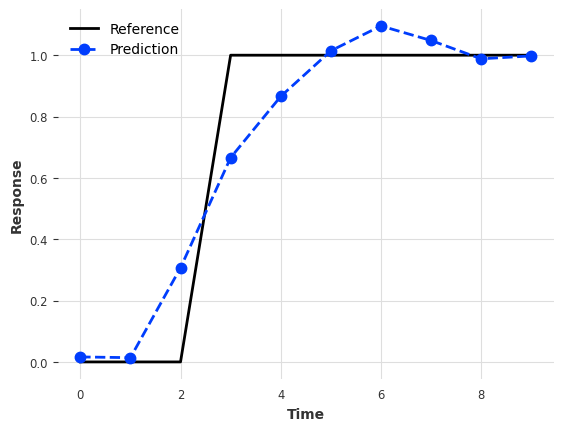

In [8]:
# Initial value at time = k
Ref_traj = np.array([0,0,0,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,4,4,4,4,5,5,5,5,4,4,4,4,3,3,3,3,1,1,1,1,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6])
u = np.ones(window) * 0
y = np.ones(window) * 0
SP_hat = Ref_traj[0:P]

# Initial value at time = k+
t_hat = np.linspace(0,P-1,P)         # time stamp
y_hat = np.ones_like(t_hat) * y[-1]  # fill the gap for LSTM input
u_hat = np.ones(M) * u[-1]

# MPC Optimization: multi-starting point
n_run_opt = 1 # number of starting point
bounds = [(-100,100)] * M
multistep = 1

u_opt_temp = []
obj_opt_temp = []
pred_output_temp = []

t0 = time.time()
for i in range (n_run_opt):
    #u_hat = (np.random.rand(M))       # initial guess for the control inputs
    solution = minimize(MPC_LSTM_obj, u_hat, method='L-BFGS-B', args=(y_hat,SP_hat,u,y,window,P,M,multistep),options={'eps': 1e-03, 'ftol': 1e-03})

    u_opt_temp.append(solution.x)
    obj_opt_temp.append(pred_LSTM_output["MPC_LSTM_obj"])
    pred_output_temp.append(pred_LSTM_output["LSTM_multi_predict"])

u_opt_final = u_opt_temp[np.argmin(obj_opt_temp)]
pred_output_final_LSTM = pred_output_temp[np.argmin(obj_opt_temp)]
t1 = time.time()

print(f"LSTM single iteration time = {t1-t0}, final obj val = {np.min(obj_opt_temp)}")
print(f"best control action is {u_opt_final}")

# Print result
#print(f"initial guess = {u_hat}, optimize result = {solution.x}")
# Simulate the environment

plt.plot(SP_hat,label="Reference",linewidth=2)
plt.plot(pred_output_final_LSTM, "--.",label="Prediction", linewidth = 2, markersize=15)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Response")
plt.show()


In [9]:
pred_LSTM_output["iter"]

110

#### Run MPC in-the-loop

In [10]:
def objective_with_gradient(u_hat, y_hat, SP_hat, u, y, window, P, M, multistep):
    # Calculate objective value
    obj_value = MPC_LSTM_obj(u_hat, y_hat, SP_hat, u, y, window, P, M, multistep)
    # Calculate gradients
    obj_grad = grad_MPC_LSTM_obj(u_hat, y_hat, SP_hat, u, y, window, P, M, multistep)
    return obj_value, obj_grad

## Calculating State Matrices

In [27]:
A_matrices = []
B_matrices = []

# Initial value at time = k
#Ref_traj = np.array([0,0,0,1,1,1,1,1,1,1,1,1,1,1,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,0,0,0,0,0,0,1,1,1,1,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.2,0.5,0.3,0.1,0.01,0,0,0,0,0,0,0,0,1,1.3,1.4,1.6,1.9,1.9,1.9,1.9,2,2,2,2,2,2,2,2,2,2,1,1,1,1,0,0,0,0,0,0,0,0,0])

# Load reference trajectory
path = ''
data = pd.read_pickle(path + 'open_loop_data_SISO.pkl')
data["y"][1:] = data["y"][0:-1]

Ref_traj = np.array(data["y"][1280:])

u = np.ones(window) * 1.75
y = np.ones(window) * 1.75
SP_hat = Ref_traj[0:P]
t_hat = np.linspace(0,P-1,P)         # time stamp
y_hat = np.ones_like(t_hat) * y[-1]  # fill the gap for LSTM input
u_hat = np.ones(M) * u[-1]


MPC_result_save = dict()

real_output = np.array([])

MPC_iters = 200

# For animation
ref_traj = []
real_output_x = []
cur_x = []
cur_y = []
pred_x = []
pred_y = []

MPC_result_save = {"applied_u":[None]*MPC_iters,
                   "all_u":[None]*MPC_iters,
                   "y_hat":[None]*MPC_iters,
                   "obj":[None]*MPC_iters,
                   "observation":[None]*MPC_iters,
                   "pred_error":[None]*MPC_iters,
                   "opt_time":[None]*MPC_iters
                   }


## ========================================================================================
## ==============        MPC main loop      ===============================================
## ========================================================================================
time_sum = 0
for iter in range(MPC_iters):
    # MPC Optimization: multi-starting point
    n_run_opt = 1 # number of starting point; 1 is enough for L-BFGS-B
    multistep = 1

    u_opt_temp = []
    obj_opt_temp = []
    pred_output_temp = []

    if iter == 0:
        y_init = y[-1]
    else:
        y_init = sol[-1]

    t0 = time.time()
    for i in range (n_run_opt):
        #u_hat = (np.random.rand(M))       # initial guess for the control inputs
        solution = minimize(MPC_LSTM_obj, u_hat, method='SLSQP', jac = "True", args=(y_hat,SP_hat,u,y,window,P,M,multistep),options={'eps': 1e-03, 'ftol': 1e-03})

        u_opt_temp.append(solution.x)
        obj_opt_temp.append(pred_LSTM_output["MPC_LSTM_obj"])
        pred_output_temp.append(pred_LSTM_output["LSTM_multi_predict"])

    u_opt_final = u_opt_temp[np.argmin(obj_opt_temp)]
    pred_output_final = pred_output_temp[np.argmin(obj_opt_temp)]
    t1 = time.time()

    time_sum = time_sum + t1 - t0
    # print(f"For iter = {i}, LSTM single iteration time = {t1-t0}, final obj val = {np.min(obj_opt_temp)}")
    # print(f"best control action is {u_opt_final}")
    # print("============================================")

    # update initial condition
    u_applied = u_opt_final[0]
    y_prev = y[-1]
    
    # Simulate the environment
    # Model parameters
    K = 1 # gain
    tau = 2 # time constant
    
    uk = torch.tensor(u_opt_final[0], requires_grad=True)  # Take the first control input
    yk = torch.tensor(y[-1], requires_grad=True)  # Take the last state value
    t_hat_t = torch.from_numpy(t_hat[0:2])  # Time interval for integration
    
    soly = torch_odeint(lambda y, t: process_model(y, t, uk, K, tau), yk, t_hat_t)

    # Get the final observation (last point in the solution)
    final_observation = soly[-1]  # Last value from the simulation

    # Calculate the Jacobian with respect to y_prev and u_applied
    grad_y_prev = torch.autograd.grad(final_observation, yk, retain_graph=True)[0]
    grad_u_applied = torch.autograd.grad(final_observation, uk)[0]

    print("Final observation:", final_observation.item())
    print("Gradient with respect to y_prev:", grad_y_prev.item())
    print("Gradient with respect to u_applied:", grad_u_applied.item())

    # Simulate the environment
    # Model parameters
    K = 1 # gain
    tau = 2 # time constant
    sol = odeint(process_model,y_prev,t_hat[0:2], args=(u_applied,K,tau))
    observation = sol[[-1]].squeeze()

    MPC_result_save["applied_u"][iter]   = u_applied
    MPC_result_save["all_u"][iter]       = solution.x
    MPC_result_save["y_hat"][iter]       = pred_LSTM_output["LSTM_multi_predict"]
    MPC_result_save["obj"][iter]         = pred_LSTM_output["MPC_LSTM_obj"]
    MPC_result_save["observation"][iter] = observation
    MPC_result_save["pred_error"][iter] = float(observation - pred_LSTM_output["LSTM_multi_predict"][0].squeeze())
    MPC_result_save["opt_time"][iter] = t1-t0

    # Update recurrent inputs
    u[0:-1] = u[1:]
    u[-1]   = u_applied

    y[0:-1] = y[1:]
    y[-1]   = observation

    # Update initial guesses
    y_hat = np.ones_like(t_hat) * y[-1]  # fill the gap for LSTM input
    u_hat = np.ones(M) * u[-1]
    
    # Calculate A and B matrices at the current operating point
    A_matrix = jac_A(observation, u_applied, K, tau)
    B_matrix = jac_B(observation, u_applied, K, tau)
    A_matrices.append(A_matrix)
    B_matrices.append(B_matrix)

    # Store A and B for analysis or use within the control strategy
    print(f"Iteration {iter}: A matrix = {A_matrix}, B matrix = {B_matrix}")

    real_output = np.concatenate((real_output,sol[-1]))
    SP_hat = Ref_traj[0+iter:P+iter]

    ref_traj.append(Ref_traj[0:P+MPC_iters])
    real_output_x.append(real_output[:-1])
    cur_x.append(iter-1)
    cur_y.append(y_init)
    pred_x.append(np.linspace(iter-1,iter+P,P))
    pred_y.append(np.vstack((y_init,pred_output_final[1:])))

Final observation: 2.4069930858538338
Gradient with respect to y_prev: 0.9999999999999998
Gradient with respect to u_applied: 0.4999999999999999
Iteration 0: A matrix = -0.5, B matrix = 0.5
Final observation: 2.4326777788958833
Gradient with respect to y_prev: 0.9999999999999998
Gradient with respect to u_applied: 0.5
Iteration 1: A matrix = -0.5, B matrix = 0.5
Final observation: 2.4423527161628162
Gradient with respect to y_prev: 1.0
Gradient with respect to u_applied: 0.4999999999999999
Iteration 2: A matrix = -0.5, B matrix = 0.5
Final observation: 2.4449545083056456
Gradient with respect to y_prev: 1.0
Gradient with respect to u_applied: 0.5000000000000001
Iteration 3: A matrix = -0.5, B matrix = 0.5
Final observation: 2.4398015570147358
Gradient with respect to y_prev: 1.0
Gradient with respect to u_applied: 0.5000000000000002
Iteration 4: A matrix = -0.5, B matrix = 0.5
Final observation: 2.4370405790502536
Gradient with respect to y_prev: 1.0
Gradient with respect to u_applied:

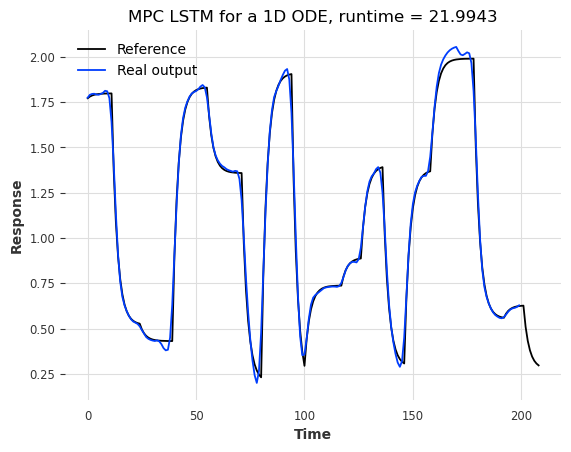

In [28]:
# Plot the result
plt.plot(Ref_traj[0:P+iter],label="Reference")
plt.plot(real_output, label = "Real output")
plt.xlabel("Time")
plt.ylabel("Response")
plt.title(f"MPC LSTM for a 1D ODE, runtime = {time_sum:.4f}")
plt.legend()
plt.show()

### Injecting Noise

In [25]:
A_matrices = []
B_matrices = []

# Initial value at time = k
#Ref_traj = np.array([0,0,0,1,1,1,1,1,1,1,1,1,1,1,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,0,0,0,0,0,0,1,1,1,1,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.2,0.5,0.3,0.1,0.01,0,0,0,0,0,0,0,0,1,1.3,1.4,1.6,1.9,1.9,1.9,1.9,2,2,2,2,2,2,2,2,2,2,1,1,1,1,0,0,0,0,0,0,0,0,0])

# Load reference trajectory
path = ''
data = pd.read_pickle(path + 'open_loop_data_SISO.pkl')
data["y"][1:] = data["y"][0:-1]

Ref_traj = np.array(data["y"][1280:])

u = np.ones(window) * 1.75
y = np.ones(window) * 1.75
SP_hat = Ref_traj[0:P]
t_hat = np.linspace(0,P-1,P)         # time stamp
y_hat = np.ones_like(t_hat) * y[-1]  # fill the gap for LSTM input
u_hat = np.ones(M) * u[-1]


MPC_result_save = dict()

real_output = np.array([])

MPC_iters = 200

# For animation
ref_traj = []
real_output_x = []
cur_x = []
cur_y = []
pred_x = []
pred_y = []

MPC_result_save = {"applied_u":[None]*MPC_iters,
                   "all_u":[None]*MPC_iters,
                   "y_hat":[None]*MPC_iters,
                   "obj":[None]*MPC_iters,
                   "observation":[None]*MPC_iters,
                   "pred_error":[None]*MPC_iters,
                   "opt_time":[None]*MPC_iters
                   }


## ========================================================================================
## ==============        MPC main loop      ===============================================
## ========================================================================================
time_sum = 0
for iter in range(MPC_iters):
    # MPC Optimization: multi-starting point
    n_run_opt = 1 # number of starting point; 1 is enough for L-BFGS-B
    multistep = 1

    u_opt_temp = []
    obj_opt_temp = []
    pred_output_temp = []

    if iter == 0:
        y_init = y[-1]
    else:
        y_init = sol[-1]

    t0 = time.time()
    for i in range (n_run_opt):
        #u_hat = (np.random.rand(M))       # initial guess for the control inputs
        solution = minimize(MPC_LSTM_obj, u_hat, method='SLSQP', jac = "True", args=(y_hat,SP_hat,u,y,window,P,M,multistep),options={'eps': 1e-03, 'ftol': 1e-03})

        u_opt_temp.append(solution.x)
        obj_opt_temp.append(pred_LSTM_output["MPC_LSTM_obj"])
        pred_output_temp.append(pred_LSTM_output["LSTM_multi_predict"])

    u_opt_final = u_opt_temp[np.argmin(obj_opt_temp)]
    pred_output_final = pred_output_temp[np.argmin(obj_opt_temp)]
    t1 = time.time()

    time_sum = time_sum + t1 - t0
    # print(f"For iter = {i}, LSTM single iteration time = {t1-t0}, final obj val = {np.min(obj_opt_temp)}")
    # print(f"best control action is {u_opt_final}")
    # print("============================================")

    # update initial condition
    u_applied = u_opt_final[0]
    y_prev = y[-1]
    
    # Simulate the environment
    # Model parameters
    K = 1 # gain
    tau = 2 # time constant
    
    uk = torch.tensor(u_opt_final[0], requires_grad=True)  # Take the first control input
    yk = torch.tensor(y[-1], requires_grad=True)  # Take the last state value
    t_hat_t = torch.from_numpy(t_hat[0:2])  # Time interval for integration
    
    #soly = torch_odeint(lambda y, t: process_model(y, t, uk, K, tau), yk, t_hat_t)
    soly = torch_odeint(lambda y, t: process_model(y, t, uk, K, tau), yk, t_hat_t)

    # Get the final observation (last point in the solution)
    final_observation = soly[-1]  # Last value from the simulation

    # Calculate the Jacobian with respect to y_prev and u_applied
    grad_y_prev = torch.autograd.grad(final_observation, yk, retain_graph=True)[0]
    grad_u_applied = torch.autograd.grad(final_observation, uk)[0]

    print("Final observation:", final_observation.item())
    print("Gradient with respect to y_prev:", grad_y_prev.item())
    print("Gradient with respect to u_applied:", grad_u_applied.item())

    # Simulate the environment
    # Model parameters
    K = 1 # gain
    tau = 2 # time constant
    sol = odeint(process_model,y_prev,t_hat[0:2], args=(u_applied,K,tau)) + (torch.rand(1)*0.05 - 0.025).item()
    observation = sol[[-1]].squeeze()

    MPC_result_save["applied_u"][iter]   = u_applied
    MPC_result_save["all_u"][iter]       = solution.x
    MPC_result_save["y_hat"][iter]       = pred_LSTM_output["LSTM_multi_predict"]
    MPC_result_save["obj"][iter]         = pred_LSTM_output["MPC_LSTM_obj"]
    MPC_result_save["observation"][iter] = observation
    MPC_result_save["pred_error"][iter] = float(observation - pred_LSTM_output["LSTM_multi_predict"][0].squeeze())
    MPC_result_save["opt_time"][iter] = t1-t0

    # Update recurrent inputs
    u[0:-1] = u[1:]
    u[-1]   = u_applied

    y[0:-1] = y[1:]
    y[-1]   = observation

    # Update initial guesses
    y_hat = np.ones_like(t_hat) * y[-1]  # fill the gap for LSTM input
    u_hat = np.ones(M) * u[-1]
    
    # Calculate A and B matrices at the current operating point
    A_matrix = jac_A(observation, u_applied, K, tau)
    B_matrix = jac_B(observation, u_applied, K, tau)
    A_matrices.append(A_matrix)
    B_matrices.append(B_matrix)

    # Store A and B for analysis or use within the control strategy
    print(f"Iteration {iter}: A matrix = {A_matrix}, B matrix = {B_matrix}")

    real_output = np.concatenate((real_output,sol[-1]))
    SP_hat = Ref_traj[0+iter:P+iter]

    ref_traj.append(Ref_traj[0:P+MPC_iters])
    real_output_x.append(real_output[:-1])
    cur_x.append(iter-1)
    cur_y.append(y_init)
    pred_x.append(np.linspace(iter-1,iter+P,P))
    pred_y.append(np.vstack((y_init,pred_output_final[1:])))

Final observation: 2.4069930858538338
Gradient with respect to y_prev: 0.9999999999999998
Gradient with respect to u_applied: 0.4999999999999999
Iteration 0: A matrix = -0.5, B matrix = 0.5
Final observation: 2.4217829246085443
Gradient with respect to y_prev: 1.0
Gradient with respect to u_applied: 0.49999999999999994
Iteration 1: A matrix = -0.5, B matrix = 0.5
Final observation: 2.4349717173224823
Gradient with respect to y_prev: 1.0000000000000002
Gradient with respect to u_applied: 0.4999999999999999
Iteration 2: A matrix = -0.5, B matrix = 0.5
Final observation: 2.4371475029213605
Gradient with respect to y_prev: 1.0000000000000002
Gradient with respect to u_applied: 0.5000000000000001
Iteration 3: A matrix = -0.5, B matrix = 0.5
Final observation: 2.4257058762539856
Gradient with respect to y_prev: 0.9999999999999997
Gradient with respect to u_applied: 0.49999999999999994
Iteration 4: A matrix = -0.5, B matrix = 0.5
Final observation: 2.422647892068837
Gradient with respect to y

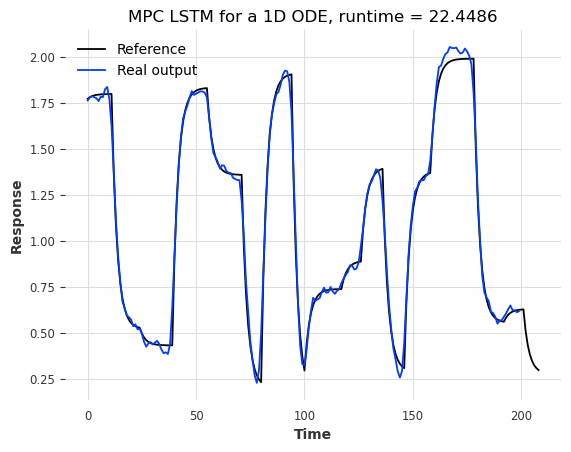

In [26]:
# Plot the result
plt.plot(Ref_traj[0:P+iter],label="Reference")
plt.plot(real_output, label = "Real output")
plt.xlabel("Time")
plt.ylabel("Response")
plt.title(f"MPC LSTM for a 1D ODE, runtime = {time_sum:.4f}")
plt.legend()
plt.show()

## Successful implementation of the Torch.Autograd code

In [19]:
A_matrices = []
B_matrices = []
grad_Y_scaled_qs = []

# Initial value at time = k
#Ref_traj = np.array([0,0,0,1,1,1,1,1,1,1,1,1,1,1,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,0,0,0,0,0,0,1,1,1,1,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.2,0.5,0.3,0.1,0.01,0,0,0,0,0,0,0,0,1,1.3,1.4,1.6,1.9,1.9,1.9,1.9,2,2,2,2,2,2,2,2,2,2,1,1,1,1,0,0,0,0,0,0,0,0,0])

# Load reference trajectory
path = ''
data = pd.read_pickle(path + 'open_loop_data_SISO.pkl')
data["y"][1:] = data["y"][0:-1]


Ref_traj = np.array(data["y"][1280:])

u = np.ones(window) * 1.75
y = np.ones(window) * 1.75
SP_hat = Ref_traj[0:P]
t_hat = np.linspace(0,P-1,P)         # time stamp
y_hat = np.ones_like(t_hat) * y[-1]  # fill the gap for LSTM input
u_hat = np.ones(M) * u[-1]


MPC_result_save = dict()

real_output = np.array([])

MPC_iters = 200

# For animation
ref_traj = []
real_output_x = []
cur_x = []
cur_y = []
pred_x = []
pred_y = []

MPC_result_save = {"applied_u":[None]*MPC_iters,
                   "all_u":[None]*MPC_iters,
                   "y_hat":[None]*MPC_iters,
                   "obj":[None]*MPC_iters,
                   "observation":[None]*MPC_iters,
                   "pred_error":[None]*MPC_iters,
                   "opt_time":[None]*MPC_iters
                   }


## ========================================================================================
## ==============        MPC main loop      ===============================================
## ========================================================================================
time_sum = 0
for iter in range(MPC_iters):
    
    print(f"\nIteration {iter}:")
    # MPC Optimization: multi-starting point
    n_run_opt = 1 # number of starting point; 1 is enough for L-BFGS-B
    multistep = 1

    u_opt_temp = []
    obj_opt_temp = []
    pred_output_temp = []

    if iter == 0:
        y_init = y[-1]
    else:
        y_init = sol[-1]

    t0 = time.time()
    for i in range (n_run_opt):
        #u_hat = (np.random.rand(M))       # initial guess for the control inputs
        solution = minimize(MPC_LSTM_obj, u_hat, method='SLSQP', jac = "True", args=(y_hat,SP_hat,u,y,window,P,M,multistep),options={'eps': 1e-03, 'ftol': 1e-03})

        u_opt_temp.append(solution.x)
        obj_opt_temp.append(pred_LSTM_output["MPC_LSTM_obj"])
        pred_output_temp.append(pred_LSTM_output["LSTM_multi_predict"])

    u_opt_final = u_opt_temp[np.argmin(obj_opt_temp)]
    pred_output_final = pred_output_temp[np.argmin(obj_opt_temp)]
    t1 = time.time()

    time_sum = time_sum + t1 - t0
    # print(f"For iter = {i}, LSTM single iteration time = {t1-t0}, final obj val = {np.min(obj_opt_temp)}")
    # print(f"best control action is {u_opt_final}")
    # print("============================================")

    # update initial condition
    u_applied = u_opt_final[0]
    y_prev = y[-1]
    
    # Simulate the environment
    # Model parameters
    K = 1 # gain
    tau = 2 # time constant
    
    # Ensure consistent data types for all tensors
    float_dtype = torch.float32  # Specify the desired data type

    u_all = np.concatenate((u, u_hat), axis = None) # len(u_all) and len(y_all) should be window+P for it appends the initial value to the list
    y_all = np.append(y,y_hat)

    # Normalize input, output
    X = np.transpose([u_all, y_all])
    Y = np.transpose([y_all])


    X_scaled = scaler_1.transform(X)
    Y_scaled = scaler_2.transform(Y)

    # Appending the window (past) and Prediction (future) arrays
    X_scaled_q = X_scaled.copy()
    Y_scaled_q = Y_scaled.copy()

    # Reshape to fit into LSTM
    X_in_LSTM = X_scaled_q.reshape((1,window+P,np.shape(X_scaled_q)[1]))
    # Convert it into torch tensor
    X_in_LSTM = torch.from_numpy(X_in_LSTM).type(torch.float32).to(device)
    X_in_LSTM.requires_grad_(True)    
    # Isolate the row where you want to set requires_grad=True
    #target_row = X_in_LSTM[:, window, :]

    # Set requires_grad=True for the target row
    #target_row.requires_grad_(True)

    # Recombine with the original tensor
    #X_in_LSTM[:, window, :] = target_row  # Reinsert the modified row into the original tensor
    #print("X_in_LSTM:", X_in_LSTM)
    # LSTM prediction
    Y_scaled_q = pred_LSTM(X_in_LSTM).detach().to("cpu").numpy().reshape(-1,1)
    Y_trial = pred_LSTM(X_in_LSTM)
    #print("y:", Y_trial)
    Y_trial_0 = Y_trial[0,0]
    Y_trial_0.backward()   
    output = pred_LSTM(X_in_LSTM)
    #print("Output:", output)
    #output[0,5] = output[0,0]
    #print("Output:", output)
    
    grad_Y_scaled_q = torch.autograd.grad(output[0,0], X_in_LSTM, grad_outputs=torch.ones_like(Y_trial[0,0]), allow_unused=True, create_graph=True)
    grad_Y_scaled_qs.append(grad_Y_scaled_q[0][0][4])
    #print("Gradient of Y_scaled_q with respect to target_row:", grad_Y_scaled_q)
    print("Gradient of Y_scaled_q with respect to target_row:", grad_Y_scaled_q[0][0][5])
    print("Gradient of Y_trial with respect to target_row:", X_in_LSTM.grad[0][5])
    print("\n")
    #print("Gradient with respect to uk:", grad_u_applied)
    
    # Simulate the environment
    # Model parameters
    K = 1 # gain
    tau = 2 # time constant
    sol = odeint(process_model,y_prev,t_hat[0:2], args=(u_applied,K,tau))
    observation = sol[[-1]].squeeze()

    MPC_result_save["applied_u"][iter]   = u_applied
    MPC_result_save["all_u"][iter]       = solution.x
    MPC_result_save["y_hat"][iter]       = pred_LSTM_output["LSTM_multi_predict"]
    MPC_result_save["obj"][iter]         = pred_LSTM_output["MPC_LSTM_obj"]
    MPC_result_save["observation"][iter] = observation
    MPC_result_save["pred_error"][iter] = float(observation - pred_LSTM_output["LSTM_multi_predict"][0].squeeze())
    MPC_result_save["opt_time"][iter] = t1-t0

    # Update recurrent inputs
    u[0:-1] = u[1:]
    u[-1]   = u_applied

    y[0:-1] = y[1:]
    y[-1]   = observation

    # Update initial guesses
    y_hat = np.ones_like(t_hat) * y[-1]  # fill the gap for LSTM input
    u_hat = np.ones(M) * u[-1]
    
    # Calculate A and B matrices at the current operating point
    A_matrix = jac_A(observation, u_applied, K, tau)
    B_matrix = jac_B(observation, u_applied, K, tau)
    A_matrices.append(A_matrix)
    B_matrices.append(B_matrix)

    # Store A and B for analysis or use within the control strategy
    print(f"Iteration {iter}: A matrix = {A_matrix}, B matrix = {B_matrix}")

    real_output = np.concatenate((real_output,sol[-1]))
    SP_hat = Ref_traj[0+iter:P+iter]

    ref_traj.append(Ref_traj[0:P+MPC_iters])
    real_output_x.append(real_output[:-1])
    cur_x.append(iter-1)
    cur_y.append(y_init)
    pred_x.append(np.linspace(iter-1,iter+P,P))
    pred_y.append(np.vstack((y_init,pred_output_final[1:])))




Iteration 0:
Gradient of Y_scaled_q with respect to target_row: tensor([0.1063, 0.0111], grad_fn=<SelectBackward0>)
Gradient of Y_trial with respect to target_row: tensor([0.1063, 0.0111])


Iteration 0: A matrix = -0.5, B matrix = 0.5

Iteration 1:
Gradient of Y_scaled_q with respect to target_row: tensor([0.1040, 0.0131], grad_fn=<SelectBackward0>)
Gradient of Y_trial with respect to target_row: tensor([0.1040, 0.0131])


Iteration 1: A matrix = -0.5, B matrix = 0.5

Iteration 2:
Gradient of Y_scaled_q with respect to target_row: tensor([0.1032, 0.0134], grad_fn=<SelectBackward0>)
Gradient of Y_trial with respect to target_row: tensor([0.1032, 0.0134])


Iteration 2: A matrix = -0.5, B matrix = 0.5

Iteration 3:
Gradient of Y_scaled_q with respect to target_row: tensor([0.1037, 0.0132], grad_fn=<SelectBackward0>)
Gradient of Y_trial with respect to target_row: tensor([0.1037, 0.0132])


Iteration 3: A matrix = -0.5, B matrix = 0.5

Iteration 4:
Gradient of Y_scaled_q with respect to

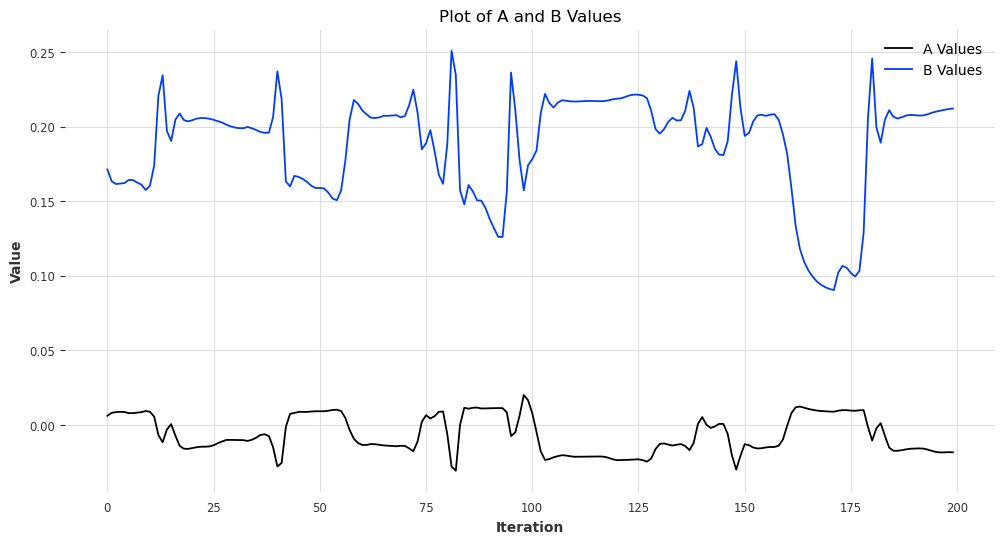

In [20]:
x = np.ones(200)
y = np.ones(200)

for i in range (0, 200):
    x[i] = grad_Y_scaled_qs[i][0]
    y[i] = grad_Y_scaled_qs[i][1]

index = np.arange(200)

# Plotting the two lists
plt.figure(figsize=(12, 6))
plt.plot(index, y, label='A Values')
plt.plot(index, x, label='B Values')
#plt.plot(index, B_matrices, label='B_matrices')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Plot of A and B Values')
plt.legend()


plt.savefig("Line Trajectory.png")

plt.grid(True)

plt.show()

In [21]:
A_matrices = []
B_matrices = []
grad_Y_scaled_qs = []

# Initial value at time = k
#Ref_traj = np.array([0,0,0,1,1,1,1,1,1,1,1,1,1,1,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,0,0,0,0,0,0,1,1,1,1,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.2,0.5,0.3,0.1,0.01,0,0,0,0,0,0,0,0,1,1.3,1.4,1.6,1.9,1.9,1.9,1.9,2,2,2,2,2,2,2,2,2,2,1,1,1,1,0,0,0,0,0,0,0,0,0])

# Load reference trajectory
path = ''
data = pd.read_pickle(path + 'open_loop_data_SISO.pkl')
data["y"][1:] = data["y"][0:-1]


Ref_traj = np.array(data["y"][1280:])

u = np.ones(window) * 1.75
y = np.ones(window) * 1.75
SP_hat = Ref_traj[0:P]
t_hat = np.linspace(0,P-1,P)         # time stamp
y_hat = np.ones_like(t_hat) * y[-1]  # fill the gap for LSTM input
u_hat = np.ones(M) * u[-1]


MPC_result_save = dict()

real_output = np.array([])

MPC_iters = 200

# For animation
ref_traj = []
real_output_x = []
cur_x = []
cur_y = []
pred_x = []
pred_y = []

MPC_result_save = {"applied_u":[None]*MPC_iters,
                   "all_u":[None]*MPC_iters,
                   "y_hat":[None]*MPC_iters,
                   "obj":[None]*MPC_iters,
                   "observation":[None]*MPC_iters,
                   "pred_error":[None]*MPC_iters,
                   "opt_time":[None]*MPC_iters
                   }


## ========================================================================================
## ==============        MPC main loop      ===============================================
## ========================================================================================
time_sum = 0
for iter in range(MPC_iters):
    
    print(f"\nIteration {iter}:")
    # MPC Optimization: multi-starting point
    n_run_opt = 1 # number of starting point; 1 is enough for L-BFGS-B
    multistep = 1

    u_opt_temp = []
    obj_opt_temp = []
    pred_output_temp = []

    if iter == 0:
        y_init = y[-1]
    else:
        y_init = sol[-1]

    t0 = time.time()
    for i in range (n_run_opt):
        #u_hat = (np.random.rand(M))       # initial guess for the control inputs
        solution = minimize(MPC_LSTM_obj, u_hat, method='SLSQP', jac = "True", args=(y_hat,SP_hat,u,y,window,P,M,multistep),options={'eps': 1e-03, 'ftol': 1e-03})

        u_opt_temp.append(solution.x)
        obj_opt_temp.append(pred_LSTM_output["MPC_LSTM_obj"])
        pred_output_temp.append(pred_LSTM_output["LSTM_multi_predict"])

    u_opt_final = u_opt_temp[np.argmin(obj_opt_temp)]
    pred_output_final = pred_output_temp[np.argmin(obj_opt_temp)]
    t1 = time.time()

    time_sum = time_sum + t1 - t0
    # print(f"For iter = {i}, LSTM single iteration time = {t1-t0}, final obj val = {np.min(obj_opt_temp)}")
    # print(f"best control action is {u_opt_final}")
    # print("============================================")

    # update initial condition
    u_applied = u_opt_final[0]
    y_prev = y[-1]
    
    # Simulate the environment
    # Model parameters
    K = 1 # gain
    tau = 2 # time constant
    
    # Ensure consistent data types for all tensors
    float_dtype = torch.float32  # Specify the desired data type

    u_all = np.concatenate((u, u_hat), axis = None) # len(u_all) and len(y_all) should be window+P for it appends the initial value to the list
    y_all = np.append(y,y_hat)

    # Normalize input, output
    X = np.transpose([u_all, y_all])
    Y = np.transpose([y_all])


    X_scaled = X
    Y_scaled = Y

    # Appending the window (past) and Prediction (future) arrays
    X_scaled_q = X_scaled.copy()
    Y_scaled_q = Y_scaled.copy()

    # Reshape to fit into LSTM
    X_in_LSTM = X_scaled_q.reshape((1,window+P,np.shape(X_scaled_q)[1]))
    # Convert it into torch tensor
    X_in_LSTM = torch.from_numpy(X_in_LSTM).type(torch.float32).to(device)
    X_in_LSTM.requires_grad_(True)    
    # Isolate the row where you want to set requires_grad=True
    #target_row = X_in_LSTM[:, window, :]

    # Set requires_grad=True for the target row
    #target_row.requires_grad_(True)

    # Recombine with the original tensor
    #X_in_LSTM[:, window, :] = target_row  # Reinsert the modified row into the original tensor
    #print("X_in_LSTM:", X_in_LSTM)
    # LSTM prediction
    Y_scaled_q = pred_LSTM(X_in_LSTM).detach().to("cpu").numpy().reshape(-1,1)
    Y_trial = pred_LSTM(X_in_LSTM)
    #print("y:", Y_trial)
    Y_trial_0 = Y_trial[0,0]
    Y_trial_0.backward()   
    output = pred_LSTM(X_in_LSTM)
    #print("Output:", output)
    #output[0,5] = output[0,0]
    #print("Output:", output)
    
    grad_Y_scaled_q = torch.autograd.grad(output[0,0], X_in_LSTM, grad_outputs=torch.ones_like(Y_trial[0,0]), allow_unused=True, create_graph=True)
    grad_Y_scaled_qs.append(grad_Y_scaled_q[0][0])
    #print("Gradient of Y_scaled_q with respect to target_row:", grad_Y_scaled_q)
    print("Gradient of Y_scaled_q with respect to target_row:", grad_Y_scaled_q[0][0][5])
    print("Gradient of Y_trial with respect to target_row:", X_in_LSTM.grad[0][5])
    print("\n")
    #print("Gradient with respect to uk:", grad_u_applied)
    
    # Simulate the environment
    # Model parameters
    K = 1 # gain
    tau = 2 # time constant
    sol = odeint(process_model,y_prev,t_hat[0:2], args=(u_applied,K,tau))
    observation = sol[[-1]].squeeze()

    MPC_result_save["applied_u"][iter]   = u_applied
    MPC_result_save["all_u"][iter]       = solution.x
    MPC_result_save["y_hat"][iter]       = pred_LSTM_output["LSTM_multi_predict"]
    MPC_result_save["obj"][iter]         = pred_LSTM_output["MPC_LSTM_obj"]
    MPC_result_save["observation"][iter] = observation
    MPC_result_save["pred_error"][iter] = float(observation - pred_LSTM_output["LSTM_multi_predict"][0].squeeze())
    MPC_result_save["opt_time"][iter] = t1-t0

    # Update recurrent inputs
    u[0:-1] = u[1:]
    u[-1]   = u_applied

    y[0:-1] = y[1:]
    y[-1]   = observation

    # Update initial guesses
    y_hat = np.ones_like(t_hat) * y[-1]  # fill the gap for LSTM input
    u_hat = np.ones(M) * u[-1]
    
    # Calculate A and B matrices at the current operating point
    A_matrix = jac_A(observation, u_applied, K, tau)
    B_matrix = jac_B(observation, u_applied, K, tau)
    A_matrices.append(A_matrix)
    B_matrices.append(B_matrix)

    # Store A and B for analysis or use within the control strategy
    print(f"Iteration {iter}: A matrix = {A_matrix}, B matrix = {B_matrix}")

    real_output = np.concatenate((real_output,sol[-1]))
    SP_hat = Ref_traj[0+iter:P+iter]

    ref_traj.append(Ref_traj[0:P+MPC_iters])
    real_output_x.append(real_output[:-1])
    cur_x.append(iter-1)
    cur_y.append(y_init)
    pred_x.append(np.linspace(iter-1,iter+P,P))
    pred_y.append(np.vstack((y_init,pred_output_final[1:])))




Iteration 0:
Gradient of Y_scaled_q with respect to target_row: tensor([-0.0633,  0.0022], grad_fn=<SelectBackward0>)
Gradient of Y_trial with respect to target_row: tensor([-0.0633,  0.0022])


Iteration 0: A matrix = -0.5, B matrix = 0.5

Iteration 1:
Gradient of Y_scaled_q with respect to target_row: tensor([-0.0627,  0.0029], grad_fn=<SelectBackward0>)
Gradient of Y_trial with respect to target_row: tensor([-0.0627,  0.0029])


Iteration 1: A matrix = -0.5, B matrix = 0.5

Iteration 2:
Gradient of Y_scaled_q with respect to target_row: tensor([-0.0633,  0.0031], grad_fn=<SelectBackward0>)
Gradient of Y_trial with respect to target_row: tensor([-0.0633,  0.0031])


Iteration 2: A matrix = -0.5, B matrix = 0.5

Iteration 3:
Gradient of Y_scaled_q with respect to target_row: tensor([-0.0634,  0.0029], grad_fn=<SelectBackward0>)
Gradient of Y_trial with respect to target_row: tensor([-0.0634,  0.0029])


Iteration 3: A matrix = -0.5, B matrix = 0.5

Iteration 4:
Gradient of Y_scaled_q

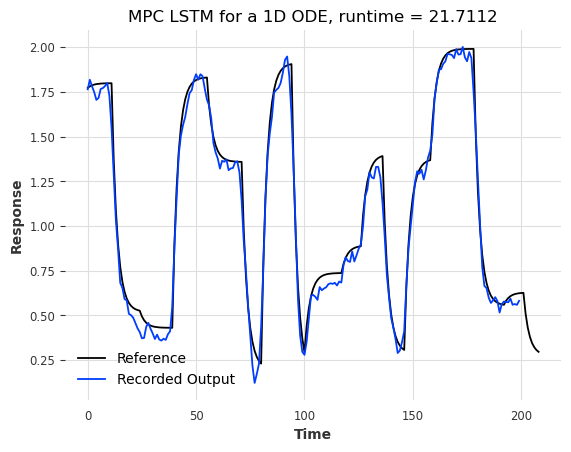

In [86]:
A_matrices = []
B_matrices = []

# Initial value at time = k
#Ref_traj = np.array([0,0,0,1,1,1,1,1,1,1,1,1,1,1,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,0,0,0,0,0,0,1,1,1,1,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.2,0.5,0.3,0.1,0.01,0,0,0,0,0,0,0,0,1,1.3,1.4,1.6,1.9,1.9,1.9,1.9,2,2,2,2,2,2,2,2,2,2,1,1,1,1,0,0,0,0,0,0,0,0,0])

# Load reference trajectory
path = ''
data = pd.read_pickle(path + 'open_loop_data_SISO.pkl')
data["y"][1:] = data["y"][0:-1]

Ref_traj = np.array(data["y"][1280:])

u = np.ones(window) * 1.75
y = np.ones(window) * 1.75
SP_hat = Ref_traj[0:P]
t_hat = np.linspace(0,P-1,P)         # time stamp
y_hat = np.ones_like(t_hat) * y[-1]  # fill the gap for LSTM input
u_hat = np.ones(M) * u[-1]

gain = 0.2# ANCILLARY CONTROLLER GAIN

MPC_result_save = dict()

real_output = np.array([])
comp_output = np.array([])

MPC_iters = 200

# For animation
ref_traj = []
real_output_x = []
cur_x = []
cur_y = []
pred_x = []
pred_y = []

MPC_result_save = {"applied_u":[None]*MPC_iters,
                   "all_u":[None]*MPC_iters,
                   "y_hat":[None]*MPC_iters,
                   "obj":[None]*MPC_iters,
                   "observation":[None]*MPC_iters,
                   "pred_error":[None]*MPC_iters,
                   "opt_time":[None]*MPC_iters
                   }


## ========================================================================================
## ==============        MPC main loop      ===============================================
## ========================================================================================
time_sum = 0
for iter in range(MPC_iters):
    # MPC Optimization: multi-starting point
    n_run_opt = 1 # number of starting point; 1 is enough for L-BFGS-B
    multistep = 1

    u_opt_temp = []
    obj_opt_temp = []
    pred_output_temp = []

    if iter == 0:
        y_init = y[-1]
    else:
        y_init = sol[-1]

    t0 = time.time()
    for i in range (n_run_opt):
        #u_hat = (np.random.rand(M))       # initial guess for the control inputs
        solution = minimize(MPC_LSTM_obj, u_hat, method='SLSQP', jac = "True", args=(y_hat,SP_hat,u,y,window,P,M,multistep),options={'eps': 1e-03, 'ftol': 1e-03})

        u_opt_temp.append(solution.x) #U pred k+1
        obj_opt_temp.append(pred_LSTM_output["MPC_LSTM_obj"])
        pred_output_temp.append(pred_LSTM_output["LSTM_multi_predict"])

    u_opt_final = u_opt_temp[np.argmin(obj_opt_temp)]
    pred_output_final = pred_output_temp[np.argmin(obj_opt_temp)]
    t1 = time.time()

    time_sum = time_sum + t1 - t0
    # print(f"For iter = {i}, LSTM single iteration time = {t1-t0}, final obj val = {np.min(obj_opt_temp)}")
    # print(f"best control action is {u_opt_final}")
    # print("============================================")

    # update initial condition
    u_pred = u_opt_final[0] #USE AS U pred k+1
    y_prev = y[-1] #USE AS Y pred
    
    if iter == 0:
        u_applied = u_pred
    else:
        #use final_observation = soly[-1] as Y real to calculate real u_applied k+1
        u_applied = u_pred - gain*(observation - y_pred)
        #print(f"u_applied: {u_applied}, u_pred: {u_pred}") 
        #print(f"observation: {observation}, y_prev: {y_prev}") 
    
    # Simulate the environment
    # Model parameters
    K = 1 # gain
    tau = 2 # time constant
    noise = (torch.rand(1)*0.1 - 0.05).item()
    #sol = odeint(process_model,y_prev,t_hat[0:2], args=(u_applied,K,tau)) + (torch.rand(1)*0.05 - 0.025).item()
    sol = odeint(process_model,y_prev,t_hat[0:2], args=(u_applied,K,tau)) + noise
    observation = sol[[-1]].squeeze()
    
    solb = odeint(process_model,y_prev,t_hat[0:2], args=(u_pred,K,tau)) + noise
    observationb = solb[[-1]].squeeze()

    MPC_result_save["applied_u"][iter]   = u_applied
    MPC_result_save["all_u"][iter]       = solution.x
    MPC_result_save["y_hat"][iter]       = pred_LSTM_output["LSTM_multi_predict"]
    MPC_result_save["obj"][iter]         = pred_LSTM_output["MPC_LSTM_obj"]
    MPC_result_save["observation"][iter] = observation
    MPC_result_save["pred_error"][iter] = float(observation - pred_LSTM_output["LSTM_multi_predict"][0].squeeze())
    MPC_result_save["opt_time"][iter] = t1-t0

    # Update recurrent inputs
    u[0:-1] = u[1:]
    u[-1]   = u_applied

    y[0:-1] = y[1:]
    y[-1]   = observation

    # Update initial guesses
    y_hat = np.ones_like(t_hat) * y[-1]  # fill the gap for LSTM input
    u_hat = np.ones(M) * u[-1]
    
    u_all = np.concatenate((u, u_hat), axis = None) # len(u_all) and len(y_all) should be window+P for it appends the initial value to the list
    y_all = np.append(y,y_hat)

    # Normalize input, output
    X = np.transpose([u_all, y_all])
    Y = np.transpose([y_all])


    X_scaled = scaler_1.transform(X)
    Y_scaled = scaler_2.transform(Y)

    # Appending the window (past) and Prediction (future) arrays
    X_scaled_q = X_scaled.copy()
    Y_scaled_q = Y_scaled.copy()

    # Reshape to fit into LSTM
    X_in_LSTM = X_scaled_q.reshape((1,window+P,np.shape(X_scaled_q)[1]))
    # Convert it into torch tensor
    X_in_LSTM = torch.from_numpy(X_in_LSTM).type(torch.float32).to(device)
    X_in_LSTM.requires_grad_(True)    
    
    Y_scaled_q = pred_LSTM(X_in_LSTM).detach().to("cpu").numpy().reshape(-1,1)
    #print(f"Y: {Y_scaled_q[0][0]}")
    
    y_pred = Y_scaled_q[0][0]
    """
    # Calculate A and B matrices at the current operating point
    A_matrix = jac_A(observation, u_applied, K, tau)
    B_matrix = jac_B(observation, u_applied, K, tau)
    A_matrices.append(A_matrix)
    B_matrices.append(B_matrix)

    # Store A and B for analysis or use within the control strategy
    print(f"Iteration {iter}: A matrix = {A_matrix}, B matrix = {B_matrix}")
    """

    real_output = np.concatenate((real_output,sol[-1]))
    comp_output = np.concatenate((comp_output,solb[-1]))
    SP_hat = Ref_traj[0+iter:P+iter]

    ref_traj.append(Ref_traj[0:P+MPC_iters])
    real_output_x.append(real_output[:-1])
    cur_x.append(iter-1)
    cur_y.append(y_init)
    pred_x.append(np.linspace(iter-1,iter+P,P))
    pred_y.append(np.vstack((y_init,pred_output_final[1:])))

# Plot the result
#plt.figure(figsize=(12, 8.5))
plt.plot(Ref_traj[0:P+iter],label="Reference")
#plt.plot(real_output, label = "Output with ancillary control")
plt.plot(comp_output, label = "Recorded Output")
plt.xlabel("Time")
plt.ylabel("Response")
plt.title(f"MPC LSTM for a 1D ODE, runtime = {time_sum:.4f}")
plt.legend()
plt.savefig("After Ancillary 0.1 error.png")
plt.show()

## Adding Noise and Implementing an Ancilllary Controller

In [78]:
A_matrices = []
B_matrices = []

# Initial value at time = k
#Ref_traj = np.array([0,0,0,1,1,1,1,1,1,1,1,1,1,1,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,0,0,0,0,0,0,1,1,1,1,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.2,0.5,0.3,0.1,0.01,0,0,0,0,0,0,0,0,1,1.3,1.4,1.6,1.9,1.9,1.9,1.9,2,2,2,2,2,2,2,2,2,2,1,1,1,1,0,0,0,0,0,0,0,0,0])

# Load reference trajectory
path = ''
data = pd.read_pickle(path + 'open_loop_data_SISO.pkl')
data["y"][1:] = data["y"][0:-1]

Ref_traj = np.array(data["y"][1280:])

u = np.ones(window) * 1.75
y = np.ones(window) * 1.75
SP_hat = Ref_traj[0:P]
t_hat = np.linspace(0,P-1,P)         # time stamp
y_hat = np.ones_like(t_hat) * y[-1]  # fill the gap for LSTM input
u_hat = np.ones(M) * u[-1]

gain = 0.2# ANCILLARY CONTROLLER GAIN

MPC_result_save = dict()

real_output = np.array([])
comp_output = np.array([])

MPC_iters = 200

# For animation
ref_traj = []
real_output_x = []
cur_x = []
cur_y = []
pred_x = []
pred_y = []

MPC_result_save = {"applied_u":[None]*MPC_iters,
                   "all_u":[None]*MPC_iters,
                   "y_hat":[None]*MPC_iters,
                   "obj":[None]*MPC_iters,
                   "observation":[None]*MPC_iters,
                   "pred_error":[None]*MPC_iters,
                   "opt_time":[None]*MPC_iters
                   }


## ========================================================================================
## ==============        MPC main loop      ===============================================
## ========================================================================================
time_sum = 0
for iter in range(MPC_iters):
    # MPC Optimization: multi-starting point
    n_run_opt = 1 # number of starting point; 1 is enough for L-BFGS-B
    multistep = 1

    u_opt_temp = []
    obj_opt_temp = []
    pred_output_temp = []

    if iter == 0:
        y_init = y[-1]
    else:
        y_init = sol[-1]

    t0 = time.time()
    for i in range (n_run_opt):
        #u_hat = (np.random.rand(M))       # initial guess for the control inputs
        solution = minimize(MPC_LSTM_obj, u_hat, method='SLSQP', jac = "True", args=(y_hat,SP_hat,u,y,window,P,M,multistep),options={'eps': 1e-03, 'ftol': 1e-03})

        u_opt_temp.append(solution.x) #U pred k+1
        obj_opt_temp.append(pred_LSTM_output["MPC_LSTM_obj"])
        pred_output_temp.append(pred_LSTM_output["LSTM_multi_predict"])

    u_opt_final = u_opt_temp[np.argmin(obj_opt_temp)]
    pred_output_final = pred_output_temp[np.argmin(obj_opt_temp)]
    t1 = time.time()

    time_sum = time_sum + t1 - t0
    # print(f"For iter = {i}, LSTM single iteration time = {t1-t0}, final obj val = {np.min(obj_opt_temp)}")
    # print(f"best control action is {u_opt_final}")
    # print("============================================")

    # update initial condition
    u_pred = u_opt_final[0] #USE AS U pred k+1
    y_prev = y[-1] #USE AS Y pred
    
    if iter == 0:
        u_applied = u_pred
    else:
        #use final_observation = soly[-1] as Y real to calculate real u_applied k+1
        u_applied = u_pred - gain*(observation - y_pred)
        #print(f"u_applied: {u_applied}, u_pred: {u_pred}") 
        #print(f"observation: {observation}, y_prev: {y_prev}") 
    
    # Simulate the environment
    # Model parameters
    K = 1 # gain
    tau = 2 # time constant
    noise = (torch.rand(1)*0.1).item()
    #sol = odeint(process_model,y_prev,t_hat[0:2], args=(u_applied,K,tau)) + (torch.rand(1)*0.05 - 0.025).item()
    sol = odeint(process_model,y_prev,t_hat[0:2], args=(u_applied,K,tau)) + noise
    observation = sol[[-1]].squeeze()
    
    solb = odeint(process_model,y_prev,t_hat[0:2], args=(u_pred,K,tau)) + noise
    observationb = solb[[-1]].squeeze()

    MPC_result_save["applied_u"][iter]   = u_applied
    MPC_result_save["all_u"][iter]       = solution.x
    MPC_result_save["y_hat"][iter]       = pred_LSTM_output["LSTM_multi_predict"]
    MPC_result_save["obj"][iter]         = pred_LSTM_output["MPC_LSTM_obj"]
    MPC_result_save["observation"][iter] = observation
    MPC_result_save["pred_error"][iter] = float(observation - pred_LSTM_output["LSTM_multi_predict"][0].squeeze())
    MPC_result_save["opt_time"][iter] = t1-t0

    # Update recurrent inputs
    u[0:-1] = u[1:]
    u[-1]   = u_applied

    y[0:-1] = y[1:]
    y[-1]   = observation

    # Update initial guesses
    y_hat = np.ones_like(t_hat) * y[-1]  # fill the gap for LSTM input
    u_hat = np.ones(M) * u[-1]
    
    u_all = np.concatenate((u, u_hat), axis = None) # len(u_all) and len(y_all) should be window+P for it appends the initial value to the list
    y_all = np.append(y,y_hat)

    # Normalize input, output
    X = np.transpose([u_all, y_all])
    Y = np.transpose([y_all])


    X_scaled = scaler_1.transform(X)
    Y_scaled = scaler_2.transform(Y)

    # Appending the window (past) and Prediction (future) arrays
    X_scaled_q = X_scaled.copy()
    Y_scaled_q = Y_scaled.copy()

    # Reshape to fit into LSTM
    X_in_LSTM = X_scaled_q.reshape((1,window+P,np.shape(X_scaled_q)[1]))
    # Convert it into torch tensor
    X_in_LSTM = torch.from_numpy(X_in_LSTM).type(torch.float32).to(device)
    X_in_LSTM.requires_grad_(True)    
    
    Y_scaled_q = pred_LSTM(X_in_LSTM).detach().to("cpu").numpy().reshape(-1,1)
    #print(f"Y: {Y_scaled_q[0][0]}")
    
    y_pred = Y_scaled_q[0][0]
    """
    # Calculate A and B matrices at the current operating point
    A_matrix = jac_A(observation, u_applied, K, tau)
    B_matrix = jac_B(observation, u_applied, K, tau)
    A_matrices.append(A_matrix)
    B_matrices.append(B_matrix)

    # Store A and B for analysis or use within the control strategy
    print(f"Iteration {iter}: A matrix = {A_matrix}, B matrix = {B_matrix}")
    """

    real_output = np.concatenate((real_output,sol[-1]))
    comp_output = np.concatenate((comp_output,solb[-1]))
    SP_hat = Ref_traj[0+iter:P+iter]

    ref_traj.append(Ref_traj[0:P+MPC_iters])
    real_output_x.append(real_output[:-1])
    cur_x.append(iter-1)
    cur_y.append(y_init)
    pred_x.append(np.linspace(iter-1,iter+P,P))
    pred_y.append(np.vstack((y_init,pred_output_final[1:])))

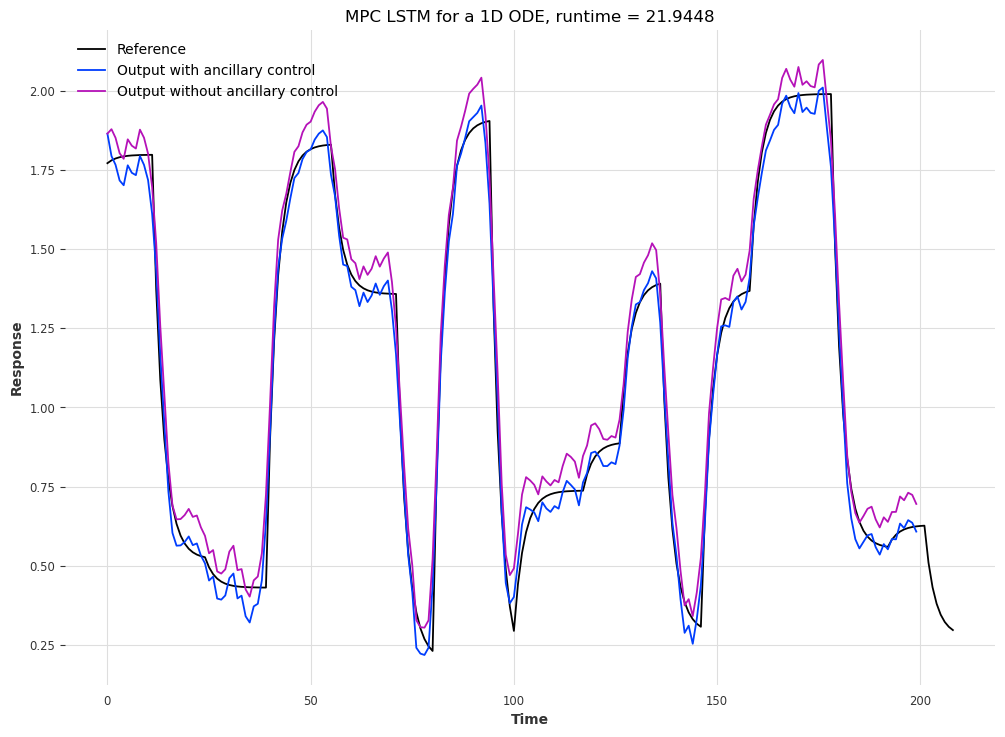

In [82]:
# Plot the result
plt.figure(figsize=(12, 8.5))
plt.plot(Ref_traj[0:P+iter],label="Reference")
plt.plot(real_output, label = "Output with ancillary control")
plt.plot(comp_output, label = "Output without ancillary control")
plt.xlabel("Time")
plt.ylabel("Response")
plt.title(f"MPC LSTM for a 1D ODE, runtime = {time_sum:.4f}")
plt.legend()
plt.savefig("After Ancillary 0.1 error.png")
plt.show()

## Solving Riccati's Equation

In [22]:
A_matrices = []
B_matrices = []
K_matrices = []  # Store gain matrices
Q = np.array([1])  # State weighting matrix
R = np.eye(1)  # Control input weighting matrix

# Initial value at time = k
#Ref_traj = np.array([0,0,0,1,1,1,1,1,1,1,1,1,1,1,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,0,0,0,0,0,0,1,1,1,1,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.2,0.5,0.3,0.1,0.01,0,0,0,0,0,0,0,0,1,1.3,1.4,1.6,1.9,1.9,1.9,1.9,2,2,2,2,2,2,2,2,2,2,1,1,1,1,0,0,0,0,0,0,0,0,0])

# Load reference trajectory
path = ''
data = pd.read_pickle(path + 'open_loop_data_SISO.pkl')
data["y"][1:] = data["y"][0:-1]

Ref_traj = np.array(data["y"][1280:])

u = np.ones(window) * 1.75
y = np.ones(window) * 1.75
SP_hat = Ref_traj[0:P]
t_hat = np.linspace(0,P-1,P)         # time stamp
y_hat = np.ones_like(t_hat) * y[-1]  # fill the gap for LSTM input
u_hat = np.ones(M) * u[-1]


MPC_result_save = dict()

real_output = np.array([])

MPC_iters = 200

# For animation
ref_traj = []
real_output_x = []
cur_x = []
cur_y = []
pred_x = []
pred_y = []

MPC_result_save = {"applied_u":[None]*MPC_iters,
                   "all_u":[None]*MPC_iters,
                   "y_hat":[None]*MPC_iters,
                   "obj":[None]*MPC_iters,
                   "observation":[None]*MPC_iters,
                   "pred_error":[None]*MPC_iters,
                   "opt_time":[None]*MPC_iters
                   }


## ========================================================================================
## ==============        MPC main loop      ===============================================
## ========================================================================================
time_sum = 0
for iter in range(MPC_iters):
    # MPC Optimization: multi-starting point
    n_run_opt = 1 # number of starting point; 1 is enough for L-BFGS-B
    multistep = 1

    u_opt_temp = []
    obj_opt_temp = []
    pred_output_temp = []

    if iter == 0:
        y_init = y[-1]
    else:
        y_init = sol[-1]

    t0 = time.time()
    for i in range (n_run_opt):
        #u_hat = (np.random.rand(M))       # initial guess for the control inputs
        solution = minimize(MPC_LSTM_obj, u_hat, method='SLSQP', jac = "True", args=(y_hat,SP_hat,u,y,window,P,M,multistep),options={'eps': 1e-03, 'ftol': 1e-03})

        u_opt_temp.append(solution.x)
        obj_opt_temp.append(pred_LSTM_output["MPC_LSTM_obj"])
        pred_output_temp.append(pred_LSTM_output["LSTM_multi_predict"])

    u_opt_final = u_opt_temp[np.argmin(obj_opt_temp)]
    pred_output_final = pred_output_temp[np.argmin(obj_opt_temp)]
    t1 = time.time()

    time_sum = time_sum + t1 - t0
    # print(f"For iter = {i}, LSTM single iteration time = {t1-t0}, final obj val = {np.min(obj_opt_temp)}")
    # print(f"best control action is {u_opt_final}")
    # print("============================================")

    # update initial condition
    u_applied = u_opt_final[0]
    y_prev = y[-1]

    # Simulate the environment
    # Model parameters
    K = 1 # gain
    tau = 2 # time constant
    sol = odeint(process_model,y_prev,t_hat[0:2], args=(u_applied,K,tau))
    observation = sol[[-1]].squeeze()

    MPC_result_save["applied_u"][iter]   = u_applied
    MPC_result_save["all_u"][iter]       = solution.x
    MPC_result_save["y_hat"][iter]       = pred_LSTM_output["LSTM_multi_predict"]
    MPC_result_save["obj"][iter]         = pred_LSTM_output["MPC_LSTM_obj"]
    MPC_result_save["observation"][iter] = observation
    MPC_result_save["pred_error"][iter] = float(observation - pred_LSTM_output["LSTM_multi_predict"][0].squeeze())
    MPC_result_save["opt_time"][iter] = t1-t0

    # Update recurrent inputs
    u[0:-1] = u[1:]
    u[-1]   = u_applied

    y[0:-1] = y[1:]
    y[-1]   = observation

    # Update initial guesses
    y_hat = np.ones_like(t_hat) * y[-1]  # fill the gap for LSTM input
    u_hat = np.ones(M) * u[-1]
    
    # Calculate A and B matrices at the current operating point
    A_matrix = jac_A(observation, u_applied, K, tau)
    B_matrix = jac_B(observation, u_applied, K, tau)
    A_matrices.append(A_matrix)
    B_matrices.append(B_matrix)
    
    X, _, _ = control.care(A_matrix, B_matrix, Q, R)
    B = np.eye(1)*B_matrix #Kludge
    
    # Calculate the optimal gain matrix K
    K = np.linalg.inv(R) @ B.T @ X
    K_matrices.append(K)

    # Store A and B for analysis or use within the control strategy
    #print(f"Iteration {iter}: A matrix = {A_matrix}, B matrix = {B_matrix}, K matrix = {K_matrix}")

    real_output = np.concatenate((real_output,sol[-1]))
    SP_hat = Ref_traj[0+iter:P+iter]

    ref_traj.append(Ref_traj[0:P+MPC_iters])
    real_output_x.append(real_output[:-1])
    cur_x.append(iter-1)
    cur_y.append(y_init)
    pred_x.append(np.linspace(iter-1,iter+P,P))
    pred_y.append(np.vstack((y_init,pred_output_final[1:])))

In [23]:
print(K_matrices[-1])

[[0.41421356]]


In [24]:
B = np.eye(1)*B_matrix
print(np.shape(B))

(1, 1)


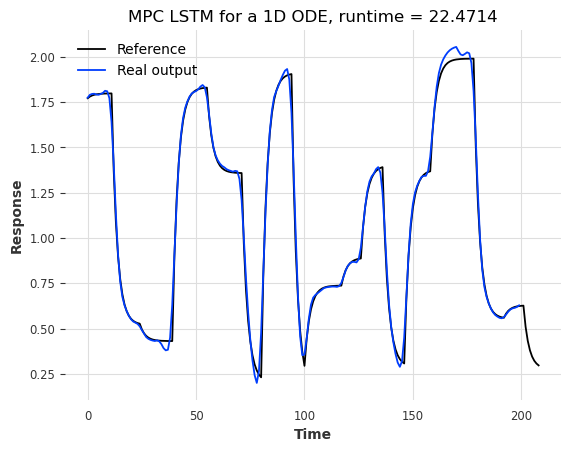

In [18]:
# Plot the result
plt.plot(Ref_traj[0:P+iter],label="Reference")
plt.plot(real_output, label = "Real output")
plt.xlabel("Time")
plt.ylabel("Response")
plt.title(f"MPC LSTM for a 1D ODE, runtime = {time_sum:.4f}")
plt.legend()
plt.show()